In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import os
import sys

In [2]:
train_dataset = dsets.MNIST(root='../data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)


test_dataset = dsets.MNIST(root='../data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [3]:
type(train_dataset[0])
print(train_dataset[0][0].size(), train_dataset[0][1])
len(train_dataset)

torch.Size([1, 28, 28]) 5


60000

In [4]:
print(test_dataset[0][0].size())
print(test_dataset[0][1], type(test_dataset[0][1]))
len(set([test_dataset[i][1] for i in range(10000) ]))

torch.Size([1, 28, 28])
7 <class 'int'>


10

In [5]:
for i in range(10):
    print(test_dataset[i][0].size(), test_dataset[i][1])

torch.Size([1, 28, 28]) 7
torch.Size([1, 28, 28]) 2
torch.Size([1, 28, 28]) 1
torch.Size([1, 28, 28]) 0
torch.Size([1, 28, 28]) 4
torch.Size([1, 28, 28]) 1
torch.Size([1, 28, 28]) 4
torch.Size([1, 28, 28]) 9
torch.Size([1, 28, 28]) 5
torch.Size([1, 28, 28]) 9


In [6]:
from random import *
class SampleMaker(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, event):
        #each event is a tuple of numpy arrays label 1,1 and dat(128,128)
        #convert to torch.floatTensor
        event2torch=event[0]       
        event_label=event[1]       
        self.memory.append([event2torch,event_label])  

  
        if len(self.memory) > self.capacity:
            del self.memory[0]
    
    def make(self, batch_size):
        samples = sample(*(self.memory, batch_size))
       
        return samples
        #return map(lambda x: Variable(torch.cat(x, 0)), samples)

In [7]:
#populate the SampleMaker 
l=60000
samplemaker=SampleMaker(capacity=l)
for i in range(l):
    #print(test_dat[i].shape, test_label[i].shape)
    samplemaker.push([train_dataset[i][0], [train_dataset[i][1]]])  

In [8]:
#### check on if the sample class outputs are oki
samples=samplemaker.make(10)
batch_labels=Variable(torch.from_numpy(np.array(list(map(lambda s:s[1],samples)))))
batch=torch.cat( map(lambda x: x[0].view(-1,28*28), samples),1).view(-1,28*28)
print(batch.size())

print(batch_labels.size())
#print(torch.from_numpy(batch_labels))
   
    

torch.Size([10, 784])
torch.Size([10, 1])


In [9]:
#####autoencoder class
input_dim=28*28
hidden_dim=10*10

#encoder = nn.Sequential(nn.Linear(input_dim,hidden1_dim),nn.Sigmoid(), nn.Linear(hidden1_dim,hidden2_dim), nn.Sigmoid())
encoder = nn.Sequential(nn.Linear(input_dim,hidden_dim),nn.Sigmoid())

#decoder = nn.Sequential(nn.Linear(hidden2_dim,hidden1_dim), nn.Sigmoid(), nn.Linear(hidden1_dim, input_dim), nn.Sigmoid())
decoder = nn.Sequential(nn.Linear(hidden_dim, input_dim), nn.Sigmoid())

autoencoder = nn.Sequential(encoder, decoder)

In [10]:
magic_num=int(np.sqrt(hidden_dim))

In [11]:
### train autoencoder using sequential model, taking in batch
input_dim=28*28
criterion = nn.MSELoss()

optimizer = optim.RMSprop(autoencoder.parameters(), lr = 0.01, weight_decay = 0.5)
s = 0.

train_loss = 0
batch_size=1000
batch_epoch=int(60000/batch_size)

#training loss
for i in range(batch_epoch):
    if os.path.isfile('ae_CNN.pth'):
        autoencoder = torch.load('ae_CNN.pth')
    else:
        pass
    sam=samplemaker.make(batch_size)
    batch=torch.cat( map(lambda x: x[0].view(-1,28*28), sam),1).view(-1,28*28)
    batch_labels=torch.from_numpy(np.array(list(map(lambda s:s[1],sam))).astype(np.int64))
    label=Variable(batch_labels)
    x_input=Variable(batch.float().view(-1,28*28)) 
    x_target=x_input
    #x_output=ae(x_input)
    x_output=autoencoder(x_input)
    optimizer.zero_grad()
    loss=criterion(x_output,x_target)
    loss.backward()
    train_loss += np.sqrt(loss.data[0])
    s += 1
    optimizer.step()

    if i%10==0:
        print(str(i)+'-th batches'+' loss: '+str(train_loss/s))

0-th batches loss: 0.468489256501
10-th batches loss: 0.468805521746
20-th batches loss: 0.46881095673
30-th batches loss: 0.468805864764
40-th batches loss: 0.468814918188
50-th batches loss: 0.468822019406


In [12]:
#save all the model for later usage
torch.save(encoder, 'AutoEncoder_encode.pth')
encode_model = torch.load('AutoEncoder_encode.pth')
torch.save(decoder, 'AutoEncoder_decode.pth')
decode_model = torch.load('AutoEncoder_decode.pth')

torch.save(autoencoder, 'ae_CNN.pth')
the_model = torch.load('ae_CNN.pth')


In [13]:
### check if the encode_model() is saved and can be used for CNN model
samples=samplemaker.make(2)
batch_labels=Variable(torch.from_numpy(np.array(list(map(lambda s:s[1],samples)))))
batch=torch.cat( map(lambda x: x[0].view(-1,28*28), samples),1).view(-1,28*28)

o=encode_model(Variable(batch.float().view(-1,28*28)))
print(o.unsqueeze(0).size())
print(batch_labels.view(2))

torch.Size([1, 2, 100])
Variable containing:
 9
 3
[torch.LongTensor of size 2]



In [26]:
sam=samplemaker.make(1000)
b=torch.cat(map(lambda x: x[0].view(-1,28*28), sam),1).view(-1,28*28)
print(b.size())
bl=torch.from_numpy(np.array(list(map(lambda s:s[1],sam))).astype(np.int64))
print(bl.size())
label=Variable(bl)
print(label.squeeze().size(), label[:10])
x_in=Variable(b.float().view(-1,28*28))
print("x_in",x_in.size())

#x_output=ae(x_input)
x=encode_model(x_in).view(-1,1,10,10)
print(x.size())
x_output=CNN(10)(x_in)
print(x_output.size())

torch.Size([1000, 784])
torch.Size([1000, 1])
torch.Size([1000]) Variable containing:
    3
    2
    7
    6
    1
    0
    1
    7
    9
    9
[torch.LongTensor of size 10x1]

x_in torch.Size([1000, 784])
torch.Size([1000, 1, 10, 10])
torch.Size([1000, 10])


In [15]:
class CNN(nn.Module):
    
    def __init__(self, num_class):
        super(CNN, self).__init__()
        self.model=encode_model
        # in_channel=1 color , out_channel=hyper param, kernerl_size=hyper param
        self.convolution1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 2)
        # in_channel=32 previous out_channel , out_channel=hyper param, kernerl_size=hyper param
        self.convolution2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 2)
        #to obtain numOfNeurons to input to fc1, we use a function count_neurons()
        self.fc1 = nn.Linear(in_features = 64, out_features = 40)
        #self.fc1= nn.Linear(64, 40)
        self.fc2 = nn.Linear(in_features = 40, out_features = num_class)

    def count_neurons(self, x):
        #image_dim=(1,80,80) obtained from image_preprocessing.py
        #x = Variable(torch.rand(1, image_dim))#create fake image comply to dimensions feed to pytorch Variable
        #print('torch Variable x',x.size())   # variable 1x1x80x80
        #[torch.FloatTensor of size 1x3136]
        x = self.model(x.view(-1,28*28))
        #print(x.size())
        x = F.relu(F.max_pool2d(self.convolution1(x.view(-1,1,magic_num,magic_num)), 3, 2))
        #print('first conv-maxpool x',x.size())# 1st conv-maxpool 1x32x37x37 torch.FloatTensor
        #print('second conv-maxpool x',x.size())#2nd conv-maxpool 1x32x17x17 
        x = F.relu(F.max_pool2d(self.convolution2(x), 3, 2))
        #print('3rd conv-maxpool x',x.size())#3rd conv-maxpool 1x64x7x7
        #pytorch trick to get shape/num of neurons out of Conv  layers
        #print('x.data',x.data) #1x64x7x7
        #print('x.data.view(1,-1)',x.data.view(1,-1))
        #x.data.view(1,-1) is a torch.FloatTensor 1x3136 
        # 0.0000  0.0000  0.0000  ...   0.1507  0.1516  0.1373 
        return x.data.view(1, -1).size(1) # class :int

    def forward(self, x):
        #print(x.size())
        y = self.model(x.view(-1,28*28)).unsqueeze(0)
        #print(y.size())
        y = F.relu(F.max_pool2d(self.convolution1(y.view(-1,1,magic_num,magic_num)), 3, 2))
        y = F.relu(F.max_pool2d(self.convolution2(y), 3, 2)) #apply max_pool2d here
        y = y.view(x.size(0), -1) # similar way to extract total num of neurons to feed fc1
        y = F.relu(self.fc1(y))
        y = self.fc2(y)
        return y


In [ ]:

def save(model):
    torch.save({'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
               }, 'CNN_with_pretrained_ae.pth')
def load(model):
    if os.path.isfile('CNN_with_pretrained_ae.pth'):
        print("=> loading checkpoint... ")
        checkpoint = torch.load('CNN_with_pretrained_ae.pth')
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("done !")
    else:
        print("no checkpoint found...")
save(ae_cnn)
load(ae_cnn)

In [16]:
ae_cnn=CNN(10)
criterion = nn.CrossEntropyLoss() #batch_size x num_class, target_of_same_batch_size
learning_rate = 0.01
optimizer = optim.Adam(ae_cnn.parameters(), lr = 0.001)

iter = 0
train_loss = 0
batch_size=1000
batch_epoch=int(60000/batch_size)
num_epoch=10
#training loss
for epoch in range(num_epoch):
    for i in range(batch_epoch):
        sam=samplemaker.make(batch_size)
        batch=torch.cat(map(lambda x: x[0].view(-1,28*28), sam),1).view(-1,28*28)
        batch_labels=torch.from_numpy(np.array(list(map(lambda s:s[1],sam))).astype(np.int64))
        label=Variable(batch_labels)
        x_input=Variable(batch.float().view(-1,28*28))
        x_target=label.squeeze()
        #x_output=ae(x_input)
        x_output=ae_cnn(x_input)
        optimizer.zero_grad()
        loss=criterion(x_output,x_target)
        loss.backward()

        optimizer.step()

        if i%10==0:
            print(str(i)+'-th batches'+' loss: '+str(loss.data[0]))

        

0-th batches loss: 2.304671287536621
10-th batches loss: 2.2940926551818848
20-th batches loss: 2.2697806358337402
30-th batches loss: 2.2000272274017334
40-th batches loss: 2.0462419986724854
50-th batches loss: 1.8514065742492676
0-th batches loss: 1.5727497339248657
10-th batches loss: 1.318742036819458
20-th batches loss: 1.059477686882019
30-th batches loss: 0.9229947924613953
40-th batches loss: 0.7712780237197876
50-th batches loss: 0.6447234153747559
0-th batches loss: 0.5454341769218445
10-th batches loss: 0.5285754203796387
20-th batches loss: 0.5023273825645447
30-th batches loss: 0.4796751141548157
40-th batches loss: 0.41517847776412964
50-th batches loss: 0.39064860343933105
0-th batches loss: 0.3688980042934418
10-th batches loss: 0.38776564598083496
20-th batches loss: 0.32530465722084045
30-th batches loss: 0.31415703892707825
40-th batches loss: 0.35670873522758484
50-th batches loss: 0.3172323405742645
0-th batches loss: 0.29623666405677795
10-th batches loss: 0.2666

In [17]:
t=Variable(test_dataset[0][0].view(-1,28*28))
l=np.array([test_dataset[0][1]]).astype(np.int64)
lt=Variable(torch.from_numpy(l))
#print(l.shape)
#print(lt.size(),lt)
#print(t.size())
#oo=CNN(10).count_neurons(t)
oo=CNN(10)(t)

print("oo.softmax",oo,F.softmax(oo))
#print(torch.max(oo.data, 1))
out=torch.max(oo.data, 1)
#print("out:{}".format(out[1]))
#print(test_dataset[0][1], type(test_dataset[0][1]))
criterion = nn.CrossEntropyLoss()
print("out[1]:{}, target:{}".format(out[1], lt))
print(out[1]-test_dataset[0][1])


oo.softmax Variable containing:
-0.0831  0.0576 -0.1173  0.0219  0.0755  0.0888  0.0846 -0.1758 -0.1257  0.0277
[torch.FloatTensor of size 1x10]
 Variable containing:
 0.0930  0.1070  0.0898  0.1032  0.1089  0.1104  0.1099  0.0847  0.0891  0.1039
[torch.FloatTensor of size 1x10]

out[1]:
 5
[torch.LongTensor of size 1]
, target:Variable containing:
 7
[torch.LongTensor of size 1]


-2
[torch.LongTensor of size 1]



In [18]:
r=len(test_dataset)
correct = 0
wrong=0

for i in range(r):
    #print(test_dataset[i][0].size(), test_dataset[i][1])
    #######################
    #  USE GPU FOR MODEL  #
    #######################
    if torch.cuda.is_available():
        images = Variable(test_dataset[i][0].view(-1,28*28).cuda())
        l=np.array([test_dataset[i][1]]).astype(np.int64)
        labels = Variable(torch.from_numpy(l).cuda())
    else:
        images = Variable(test_dataset[i][0].view(-1,28*28))
        l=np.array([test_dataset[i][1]]).astype(np.int64)
        #labels = torch.from_numpy(l)
        labels=test_dataset[i][1]
    
    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    # Forward pass to get output/logits
    outputs = ae_cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    predicted=predicted.numpy().tolist()[0]
    #print(type(predicted),predicted)
    #print(type(labels),labels)
    #prediction=predicted.numpy().tolist()[0][0]

    #print("prediction:{}, target:{}".format(predicted,labels))
    if predicted==labels:
        correct+=1
    else:
        wrong+=1
    accuracy = 100 * correct / r

# Print prediction
print('accuracy: {}. total correct: {}. total wrong: {}'.format(accuracy,correct, wrong))

accuracy: 96.12. total correct: 9612. total wrong: 388


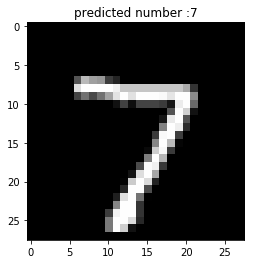

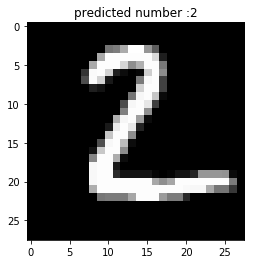

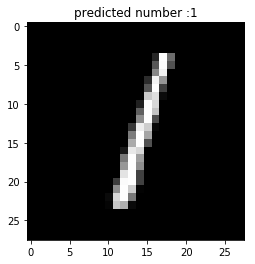

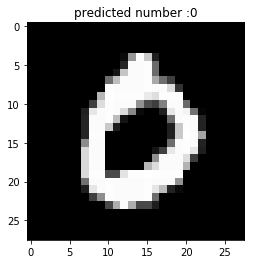

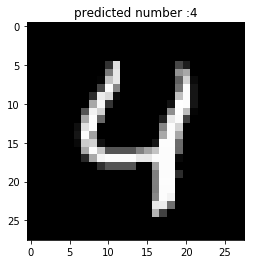

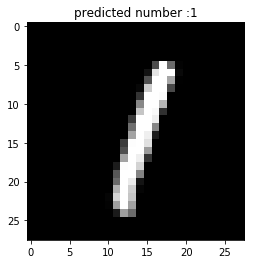

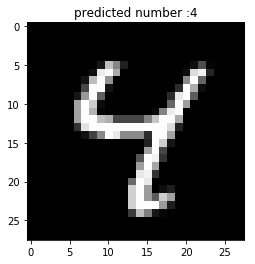

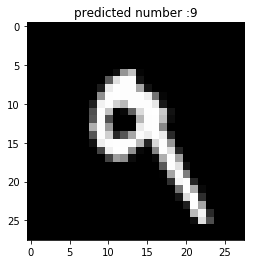

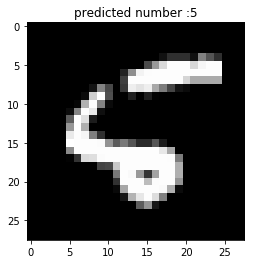

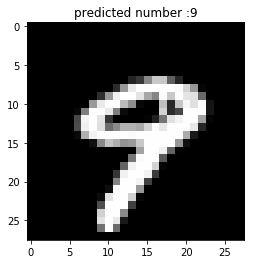

In [69]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from random import randint

for i in range(10):

    images = Variable(test_dataset[i][0].view(-1,28*28))
    l=np.array([test_dataset[i][1]]).astype(np.int64)
    #labels = torch.from_numpy(l)
    labels=test_dataset[i][1]
    
    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    # Forward pass to get output/logits
    outputs = ae_cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    predicted=predicted.numpy().tolist()[0]
    img=images.data.numpy().reshape(28,28)
    title="predicted number :"+str(predicted)
    plt.figure(i+1)
    plt.title(title)
    plt.imshow(img,cmap=plt.cm.gray)
    
